# Lab 4c. Deep Learning - iNaturalist
### Desik Somasundaram

## Import packages

In [106]:
import keras
import os, shutil
import pandas
from random import sample
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
keras.__version__

'2.6.0'

## Explore data

In [107]:
# Examine original iNat data
os. getcwd() 
dir_train_mini = "./data/train_mini"
dirs_spp = os.listdir(dir_train_mini)
n_spp = len(dirs_spp) # 10,000 species directories
n_spp 

10000

In [108]:
# Sample 10 species randomly
i10 = sample(range(1,n_spp),10)
i10

[3223, 2092, 8900, 5403, 6696, 4713, 8142, 4987, 6700, 6874]

In [109]:
# show/select the first 2 species directory names from random 10
i2 = i10[0:2]

## Copy over, Read in and Prep data

In [110]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini'

# The directory where we will
# store our smaller dataset
base_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini_subset'
# this line clears the base dir, comment out if you don't want to start over
shutil.rmtree(base_dir)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [111]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [112]:
# Select 2 species for first two parts of lab
speciesfolders = []
for i in i2:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['08204_Plantae_Tracheophyta_Magnoliopsida_Fagales_Fagaceae_Quercus_stellata',
 '04461_Animalia_Chordata_Aves_Piciformes_Picidae_Picus_canus']

In [113]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the two species selected in i2
i = 0
while i < len(i2):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [114]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i2):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [115]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [116]:
# sanity check on sizes of data splits
print('total test species 2 images:', len(os.listdir(test_species_folders[1])))

total test species 2 images: 10


In [117]:
# sanity check on sizes of data splits
print('total validation species 2 images:', len(os.listdir(validation_species_folders[1])))

total validation species 2 images: 10


In [118]:
# sanity check on sizes of data splits
print('total test species 1 images:', len(os.listdir(test_species_folders[0])))

total test species 1 images: 10


## 2 Species (binary classification) - neural net

In [176]:
# image preprocessing for model with binary classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [177]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (4, 150, 150, 3)
labels batch shape: (4,)


### Neural net model

In [178]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [179]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# custom optimizer

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#              loss='binary_crossentropy',
#             metrics=['accuracy'])

# custom optimizer and custom loss/metrics

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#             loss=losses.binary_crossentropy,
#             metrics=[metrics.binary_accuracy])

In [180]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 150, 150, 16)      64        
_________________________________________________________________
flatten_14 (Flatten)         (None, 360000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                5760016   
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 5,760,097
Trainable params: 5,760,097
Non-trainable params: 0
_________________________________________________________________


In [181]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/10
5/5 [==============================] - 1s 92ms/step - loss: 6.9762 - accuracy: 0.5500 - val_loss: 29.6256 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 0s 62ms/step - loss: 10.6360 - accuracy: 0.4500 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 0s 59ms/step - loss: 0.6922 - accuracy: 0.6500 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 0s 58ms/step - loss: 0.6941 - accuracy: 0.4000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 0s 55ms/step - loss: 0.6921 - accuracy: 0.6500 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 0s 65ms/step - loss: 0.6940 - accuracy: 0.4000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 0s 56ms/step - loss: 0.6922 - accuracy: 0.6500 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
5/5 [=========

In [182]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [183]:
model.save('2Species-binaryclassification-neuralnet.h5')

In [184]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

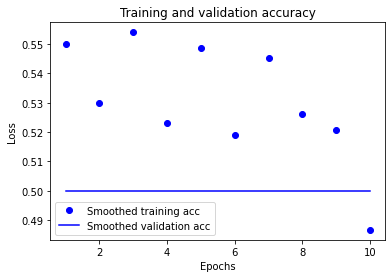

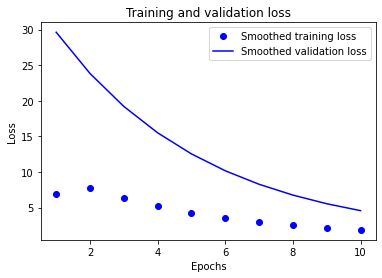

In [185]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [187]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 20 images belonging to 2 classes.
test acc: 0.5
test loss: 0.6931513547897339


## 2 Species (binary classification) - convolutional neural net

In [38]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [40]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 2s 226ms/step - loss: 0.7998 - acc: 0.4000 - val_loss: 0.6904 - val_acc: 0.5000
Epoch 2/40
5/5 [==============================] - 1s 156ms/step - loss: 0.7159 - acc: 0.4500 - val_loss: 0.6766 - val_acc: 0.5000
Epoch 3/40
5/5 [==============================] - 1s 107ms/step - loss: 0.6918 - acc: 0.5500 - val_loss: 0.6747 - val_acc: 0.6000
Epoch 4/40
5/5 [==============================] - 1s 114ms/step - loss: 0.7006 - acc: 0.4000 - val_loss: 0.6766 - val_acc: 0.5000
Epoch 5/40
5/5 [==============================] - 1s 102ms/step - loss: 0.6788 - acc: 0.4500 - val_loss: 0.6658 - val_acc: 0.6000
Epoch 6/40
5/5 [==============================] - 1s 104ms/step - loss: 0.6752 - acc: 0.6500 - val_loss: 0.6608 - val_acc: 0.6000
Epoch 7/40
5/5 [==============================] - 1s 103ms/step - loss: 0.6708 - acc: 0.6000 - val_loss: 0.6509 - val_acc: 0.6000
Epoch 8/40
5/5 [==============================] - 1s 105ms/step - loss: 0.6501 - acc: 0.70

In [41]:
model.save('2Species-binaryclassification-convnet.h5')

In [190]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

KeyError: 'acc'

In [188]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 20 images belonging to 2 classes.
test acc: 0.5
test loss: 0.6931513547897339


Write up comparing results

# 10 Species (multi-class classification) - neural net

In [191]:
# Select 10 species for second two parts of lab
speciesfolders = []
for i in i10:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['08204_Plantae_Tracheophyta_Magnoliopsida_Fagales_Fagaceae_Quercus_stellata',
 '04461_Animalia_Chordata_Aves_Piciformes_Picidae_Picus_canus',
 '08340_Plantae_Tracheophyta_Magnoliopsida_Gentianales_Rubiaceae_Galium_circaezans',
 '01944_Animalia_Arthropoda_Insecta_Lepidoptera_Nymphalidae_Parantica_aglea',
 '09099_Plantae_Tracheophyta_Magnoliopsida_Oxalidales_Oxalidaceae_Oxalis_luteola',
 '09029_Plantae_Tracheophyta_Magnoliopsida_Myrtales_Onagraceae_Chylismia_brevipes',
 '09708_Plantae_Tracheophyta_Magnoliopsida_Solanales_Convolvulaceae_Ipomoea_triloba',
 '03824_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Haemorhous_mexicanus',
 '06202_Plantae_Tracheophyta_Liliopsida_Liliales_Melanthiaceae_Trillium_nivale',
 '07990_Plantae_Tracheophyta_Magnoliopsida_Fabales_Fabaceae_Lespedeza_cuneata']

In [192]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the ten species selected in i10
i = 0
while i < len(i10):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [193]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i10):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [194]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [195]:
# sanity check on sizes of data splits
print('total test species 3 images:', len(os.listdir(test_species_folders[2])))

total test species 3 images: 10


In [196]:
# sanity check on sizes of data splits
print('total validation species 9 images:', len(os.listdir(validation_species_folders[8])))

total validation species 9 images: 10


In [197]:
# image preprocessing for model with multi classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [198]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (4, 150, 150, 3)
labels batch shape: (4, 10)


### Neural net model

In [199]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(150,150,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [200]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [201]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 150, 150, 64)      256       
_________________________________________________________________
flatten_15 (Flatten)         (None, 1440000)           0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                92160064  
_________________________________________________________________
dense_42 (Dense)             (None, 10)                650       
Total params: 92,160,970
Trainable params: 92,160,970
Non-trainable params: 0
_________________________________________________________________


In [202]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 2s 330ms/step - loss: 217.7871 - accuracy: 0.1000 - val_loss: 72.7469 - val_accuracy: 0.2500
Epoch 2/40
5/5 [==============================] - 1s 297ms/step - loss: 126.6181 - accuracy: 0.0500 - val_loss: 74.6863 - val_accuracy: 0.1500
Epoch 3/40
5/5 [==============================] - 1s 299ms/step - loss: 56.0914 - accuracy: 0.0500 - val_loss: 51.3733 - val_accuracy: 0.2000
Epoch 4/40
5/5 [==============================] - 1s 294ms/step - loss: 34.2824 - accuracy: 0.2000 - val_loss: 50.1907 - val_accuracy: 0.0500
Epoch 5/40
5/5 [==============================] - 2s 294ms/step - loss: 39.9062 - accuracy: 0.0500 - val_loss: 22.1763 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 1s 304ms/step - loss: 35.6382 - accuracy: 0.1000 - val_loss: 31.6504 - val_accuracy: 0.1000
Epoch 7/40
5/5 [==============================] - 1s 296ms/step - loss: 26.1436 - accuracy: 0.2000 - val_loss: 22.1768 - val_accuracy: 0.2000


In [83]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
model.save('10Species-multiclassification-neuralnet.h5')

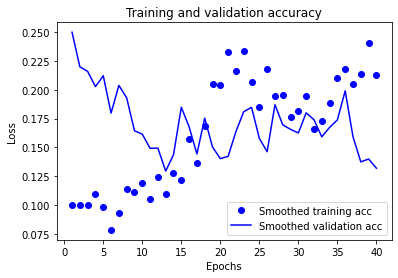

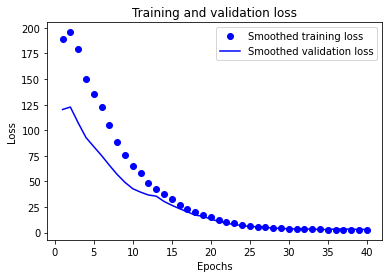

In [85]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [86]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 100 images belonging to 10 classes.
test acc: 0.20000000298023224


## 10 Species (multi classification) - convolutional neural net

In [94]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

In [96]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 1s 128ms/step - loss: 3.7480 - accuracy: 0.1000 - val_loss: 3.5155 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 0s 94ms/step - loss: 2.7123 - accuracy: 0.0000e+00 - val_loss: 2.3050 - val_accuracy: 0.1000
Epoch 3/40
5/5 [==============================] - 0s 91ms/step - loss: 2.3205 - accuracy: 0.0500 - val_loss: 2.2940 - val_accuracy: 0.1500
Epoch 4/40
5/5 [==============================] - 0s 89ms/step - loss: 2.3114 - accuracy: 0.0000e+00 - val_loss: 2.3130 - val_accuracy: 0.1000
Epoch 5/40
5/5 [==============================] - 0s 96ms/step - loss: 2.3091 - accuracy: 0.1000 - val_loss: 2.3014 - val_accuracy: 0.1500
Epoch 6/40
5/5 [==============================] - 0s 95ms/step - loss: 2.2732 - accuracy: 0.0500 - val_loss: 2.3920 - val_accuracy: 0.0500
Epoch 7/40
5/5 [==============================] - 0s 87ms/step - loss: 2.3053 - accuracy: 0.1000 - val_loss: 2.3494 - val_accuracy: 0.3000
Epoch 8/40
5/5

In [97]:
model.save('10Species-multiclassification-convnet.h5')

In [98]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

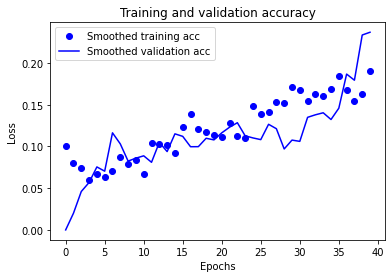

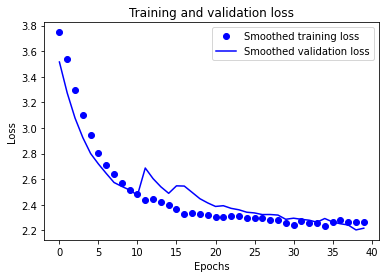

In [99]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Write up comparing results

In [100]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 100 images belonging to 10 classes.
test acc: 0.25
